In [1]:
!apt-get update && apt-get upgrade -y
!apt install -y libgl1-mesa-dev
!apt install -y libglib2.0-0

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu focal InRelease                         
Get:6 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]    
Get:7 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Fetched 336 kB in 2s (209 kB/s)                                  
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
Calculating upgrade... Done
The following packages have been kept back:
  libnvinfer-plugin7 libnvinfer7
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.
Reading package lists... Done
Building

In [2]:
!pip install opencv-python
!pip install tqdm
!pip install scikit-learn

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
!nvidia-smi

Sat Nov 26 01:23:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 32%   32C    P8    21W / 340W |     17MiB / 10240MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from IPython.display import Image, display

In [5]:
from matplotlib import pyplot as plt

In [6]:
import cv2
from PIL import ImageFile
from PIL import Image

In [7]:
import keras
from keras.models import load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

In [8]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [9]:
import random
import tqdm
import glob

In [10]:
from datetime import datetime

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
import sys
import pathlib
import os
import shutil
import math

In [13]:
import numpy as np

In [26]:
window_width = 256
window_height = 256
model_name="scannoise_remover"
do_imagesplit="no"
page_name="B-011_addnoise"

In [15]:
def ImgSplit(filename, out_dirname):
    height = window_height
    width = window_width
    
    im = cv2.imread(filename)
    output_filename_woext = os.path.splitext(os.path.basename(filename))[0]
    output_dir = os.path.split(os.path.dirname(filename))
    os.makedirs(out_dirname +"/" + output_dir[-1], exist_ok=True) 
    img_height, img_width = im.shape[:2]
    # do not make a patch when image patch is too small
    if (img_height < window_height) or (img_width < window_width):
        return
    split_height = int(img_height / height) 
    split_width = int(img_width / width)
    for h1 in range(split_height+1):
        for w1 in range(split_width+1):
            w2 = w1 * width
            h2 = h1 * height
            _h_start = h2
            _h_end   = height+h2-1
            _w_start = w2
            _w_end   = width+w2-1
            if h1 == split_height:
                _h_start = img_height-height
                _h_end   = img_height-1
            if w1 == split_width:
                _w_start = img_width-width
                _w_end   = img_width-1
            c = im[_h_start:_h_end+1, _w_start:_w_end+1]
            if (_h_end+1 - _h_start) == height and (_w_end+1 - _w_start) == width:
                cv2.imwrite(out_dirname +"/" + output_dir[-1] + "/" + output_filename_woext + "_" + str(h1).zfill(3) + "_" + str(w1).zfill(3) +".png",c)

In [16]:
if do_imagesplit == "yes":
    filenames_list=glob.glob('bookscan_linefix/groundtruth/Z/*.jpg')    
    for _filename in tqdm.tqdm(filenames_list):
        ImgSplit(_filename, out_dirname = "clean")

In [17]:
filename_list=sorted(glob.glob('clean/Z/' + page_name + '*png'))
#print(filename_list)
counter = len(filename_list)

print("total images",counter)

total images 272


In [18]:
Images4denoise = np.array([np.array(Image.open(file)) for file in filename_list])

Images4denoise = Images4denoise.astype('float32')
Images4denoise /= 255

print("Images4denoise.shape", Images4denoise.shape)

Images4denoise.shape (272, 384, 256, 3)


In [19]:
model = load_model(model_name +".023.h5")
#model.summary() #モデル情報を出力
with tf.device('/cpu:0'):
    magazine_test = model.predict(Images4denoise)

9/9 [==============================] - 28s 3s/step


In [20]:
# definition to show original image and reconstructed image
def showOrigDec(orig, noise, num = 4):
    import matplotlib.pyplot as plt
    n = num
    plt.figure()
    orig *= 255
    orig = orig.astype('uint8') 
    noise*= 255
    noise = orig.astype('uint8')
    for i in range(n):
        # display original
        ax = plt.subplot(3, n, i+1)
        plt.imshow(orig[i].reshape(window_height, window_width, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display noisy
        ax = plt.subplot(3, n, i +1 + n)
        plt.imshow(noise[i].reshape(window_height, window_width, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        # display diff
        ax = plt.subplot(3, n, i +1 +n +n)
        diff=noise[i]-orig[i]
        im_diff_abs = np.abs(diff)
        plt.imshow(im_diff_abs.reshape(window_height, window_width, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

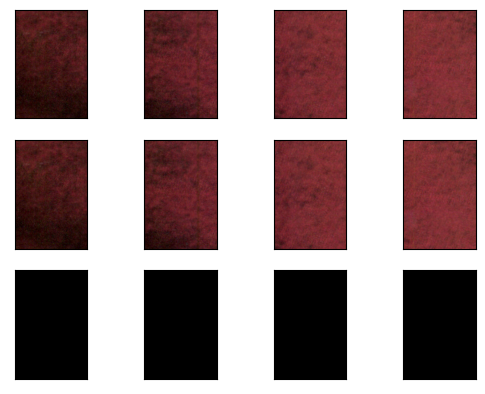

In [21]:
showOrigDec(Images4denoise[0+6:],  magazine_test[0*0+6:])

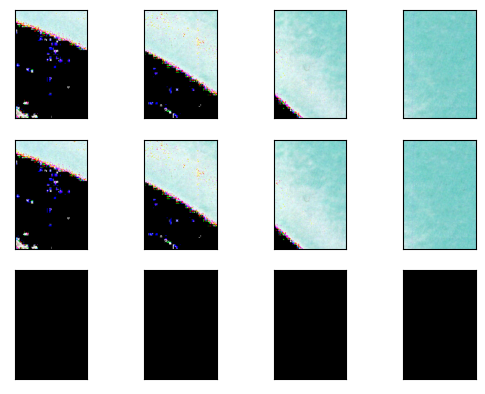

In [22]:
showOrigDec(Images4denoise[17*1+6:],  magazine_test[17*1+6:])

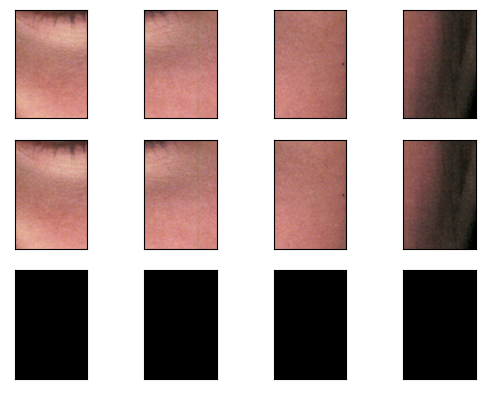

In [23]:
showOrigDec(Images4denoise[17*5+6:],  magazine_test[17*5+6:])

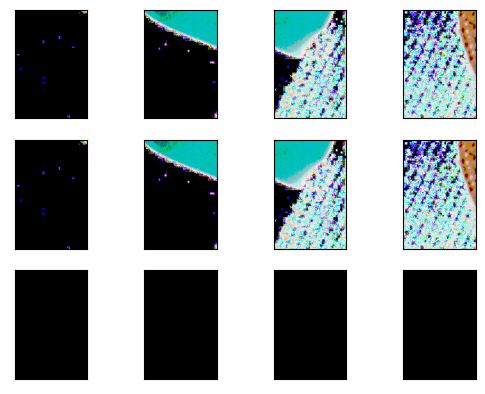

In [24]:
showOrigDec(Images4denoise[17*10+6:],  magazine_test[17*10+6:])

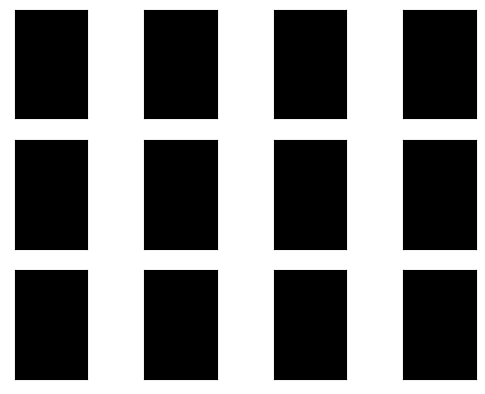

In [25]:
showOrigDec(Images4denoise[17*11+6:],  magazine_test[17*11+6:])